In [5]:
# (run once in terminal / notebook)
!pip install pandas nltk sumy gensim scikit-learn rouge-score

In [6]:
import pandas as pd
import numpy as np
import nltk, re, zipfile, os
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

nltk.download('punkt')

# 1) Unzip your dataset
zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/drive/MyDrive/archive_extracted"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 2) List files to see what’s inside
print("Extracted files:")
print(os.listdir(extract_path))

# 3) Change this once you know the correct CSV name from above print
csv_path = os.path.join(extract_path, "mtsamples.csv") # Corrected filename

# 4) Load dataset
df = pd.read_csv(csv_path)
print("DATAFRAME SHAPE:", df.shape)
print("COLUMNS:", df.columns.tolist())
print(df.head(3).to_dict(orient='records'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extracted files:
['mtsamples.csv']
DATAFRAME SHAPE: (4999, 6)
COLUMNS: ['Unnamed: 0', 'description', 'medical_specialty', 'sample_name', 'transcription', 'keywords']
[{'Unnamed: 0': 0, 'description': ' A 23-year-old white female presents with complaint of allergies.', 'medical_specialty': ' Allergy / Immunology', 'sample_name': ' Allergic Rhinitis ', 'transcription': 'SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , He

Extractive Summarization with TextRank)

In [8]:
import nltk, re
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

nltk.download('punkt')
nltk.download('punkt_tab') # Add this line to download the missing resource

# Select text column
text_col = "transcription"

# Clean text function
def clean_text(text):
    text = str(text)
    text = re.sub(r'\[\*\*.*?\*\*\]', ' ', text)   # remove MIMIC-style de-identified tags
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Example: take the first note
raw_note = df[text_col].iloc[0]
cleaned_note = clean_text(raw_note)

print("\n--- FIRST RAW NOTE (truncated to 800 chars) ---\n")
print(raw_note[:800])
print("\n--- CLEANED NOTE (truncated to 800 chars) ---\n")
print(cleaned_note[:800])

# TextRank summarization
def extractive_summary(text, sentences_count=3):
    sents = nltk.sent_tokenize(text)
    if len(sents) <= sentences_count:
        return " ".join(sents)
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    sents_out = summarizer(parser.document, sentences_count)
    return " ".join(str(s) for s in sents_out)

summary = extractive_summary(cleaned_note, sentences_count=3)
print("\n--- EXTRACTIVE SUMMARY (3 sentences) ---\n")
print(summary)

# Optional: save sample summaries
df_sample = df.head(10).copy()
df_sample["cleaned"] = df_sample[text_col].astype(str).apply(clean_text)
df_sample["summary_extractive"] = df_sample["cleaned"].apply(lambda t: extractive_summary(t, 3))
df_sample[["sample_name","medical_specialty","summary_extractive"]].to_csv("sample_summaries.csv", index=False)
print("\n✅ Saved 'sample_summaries.csv' with summaries for first 10 notes")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



--- FIRST RAW NOTE (truncated to 800 chars) ---

SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pres

--- CLEANED NOTE (truncated to 800 chars) ---

SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have all

Next Step: Make Summarization Smarter

Right now, you always take 3 sentences. But medical notes vary in length — some are short, some are very long. So let’s adjust dynamically.

✨ Improvement 1: Adaptive Sentence Count

If note < 5 sentences → return 1–2 sentences.

If note is medium (5–20 sentences) → return ~3–5 sentences.

If note is very long (>20 sentences) → return ~6–8 sentences.

In [9]:
def adaptive_summary(text):
    sents = nltk.sent_tokenize(text)
    n = len(sents)

    if n <= 5:
        count = 1
    elif n <= 20:
        count = 3
    else:
        count = 6

    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    sents_out = summarizer(parser.document, count)
    return " ".join(str(s) for s in sents_out)

# Test on first note
summary_adaptive = adaptive_summary(cleaned_note)
print("\n--- ADAPTIVE SUMMARY ---\n")
print(summary_adaptive)

# Apply to first 10
df_sample["summary_adaptive"] = df_sample["cleaned"].apply(adaptive_summary)
df_sample[["sample_name","medical_specialty","summary_adaptive"]].to_csv("sample_summaries_adaptive.csv", index=False)
print("\n✅ Saved 'sample_summaries_adaptive.csv'")



--- ADAPTIVE SUMMARY ---

She used to have allergies when she lived in Seattle but she thinks they are worse here. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. She does not think she has prescription coverage so that might be cheaper.,2.

✅ Saved 'sample_summaries_adaptive.csv'


Now let’s move to the next stage: Evaluation.
Since this dataset doesn’t provide human-written reference summaries (only full transcriptions), we can use two strategies:

🔹 Step 3: Evaluate Summaries
1. Automatic Metric (ROUGE)

ROUGE compares your generated summary against a reference summary.
👉 But since we don’t have “gold” summaries in mtsamples.csv, we can:

Use the description column (short case description) as a weak reference.

Compare our extractive summary vs that description.

Install ROUGE first:

In [10]:
!pip install rouge-score


In [11]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Example: compare summary vs description for first note
reference = str(df["description"].iloc[0])
candidate = summary_adaptive  # from adaptive summary

scores = scorer.score(reference, candidate)
print("\n--- ROUGE Evaluation ---")
print("Reference (description):", reference)
print("Candidate (summary):", candidate)
print("Scores:", scores)



--- ROUGE Evaluation ---
Reference (description):  A 23-year-old white female presents with complaint of allergies.
Candidate (summary): She used to have allergies when she lived in Seattle but she thinks they are worse here. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. She does not think she has prescription coverage so that might be cheaper.,2.
Scores: {'rouge1': Score(precision=0.011235955056179775, recall=0.09090909090909091, fmeasure=0.02), 'rougeL': Score(precision=0.011235955056179775, recall=0.09090909090909091, fmeasure=0.02)}


What This Tells Us

Extractive summaries are correct medically but don’t match the tiny descriptions in the dataset.

So, to get better scores, we need an abstractive summarizer that produces short, natural summaries closer to the dataset’s descriptions.

🔹 Next Step: Abstractive Summarization (T5-small)

We can try T5-small, which is lightweight and runs on Colab CPU/GPU without APIs.

In [12]:
!pip install transformers sentencepiece

from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load model + tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

def abstractive_summary(text, max_len=60):
    # Prepare input for T5
    input_text = "summarize: " + text
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Generate summary
    outputs = model.generate(
        inputs,
        max_length=max_len,
        min_length=15,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test on first cleaned note
print("\n--- ABSTRACTIVE SUMMARY (T5-small) ---\n")
print(abstractive_summary(cleaned_note))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


--- ABSTRACTIVE SUMMARY (T5-small) ---

the 23-year-old white female has no known medicine allergies. she has tried Claritin, and Zyrtec. she has no prescription nasal sprays.


his is way closer to the dataset’s descriptions than the extractive version, so your ROUGE scores will definitely improve.

🔹 Next Step Options

Now you can choose what to do next:

Run ROUGE evaluation again (abstractive vs description)
→ You’ll see higher precision and f-measure.

In [13]:
candidate_abs = abstractive_summary(cleaned_note)
scores_abs = scorer.score(reference, candidate_abs)
print("\n--- ROUGE for Abstractive ---")
print("Reference:", reference)
print("Candidate:", candidate_abs)
print("Scores:", scores_abs)



--- ROUGE for Abstractive ---
Reference:  A 23-year-old white female presents with complaint of allergies.
Candidate: the 23-year-old white female has no known medicine allergies. she has tried Claritin, and Zyrtec. she has no prescription nasal sprays.
Scores: {'rouge1': Score(precision=0.2608695652173913, recall=0.5454545454545454, fmeasure=0.3529411764705882), 'rougeL': Score(precision=0.2608695652173913, recall=0.5454545454545454, fmeasure=0.3529411764705882)}


Batch Summarization

Summarize first 50 or 100 notes with T5-small.

Save results to a CSV (abstractive_summaries.csv).

In [14]:
df_sample["summary_abstractive"] = df_sample["cleaned"].apply(lambda x: abstractive_summary(x, max_len=60))
df_sample[["sample_name","medical_specialty","description","summary_abstractive"]].to_csv("abstractive_summaries.csv", index=False)
print("✅ Saved abstractive summaries for sample notes")


✅ Saved abstractive summaries for sample notes


Now you have 3 strong pieces in place (preprocessing → summarization → evaluation). From here, you can:

Evaluate on the whole batch

Compute average ROUGE across 50–100 summaries.

In [15]:
scores_list = []
for i in range(len(df_sample)):
    ref = str(df_sample["description"].iloc[i])
    cand = df_sample["summary_abstractive"].iloc[i]
    scores = scorer.score(ref, cand)
    scores_list.append(scores["rouge1"].fmeasure)

print("Average ROUGE-1 F1 across sample:", sum(scores_list)/len(scores_list))


Average ROUGE-1 F1 across sample: 0.1597356231099722


Compare Extractive vs Abstractive (side by side)

Make a table with description + extractive + abstractive summary.

In [16]:
df_compare = df_sample[["sample_name","description"]].copy()
df_compare["extractive"] = df_sample["summary_adaptive"]
df_compare["abstractive"] = df_sample["summary_abstractive"]
df_compare.to_csv("comparison_summaries.csv", index=False)
print("✅ Saved comparison file")


✅ Saved comparison file


1. ROUGE Score Comparison (Bar Chart)

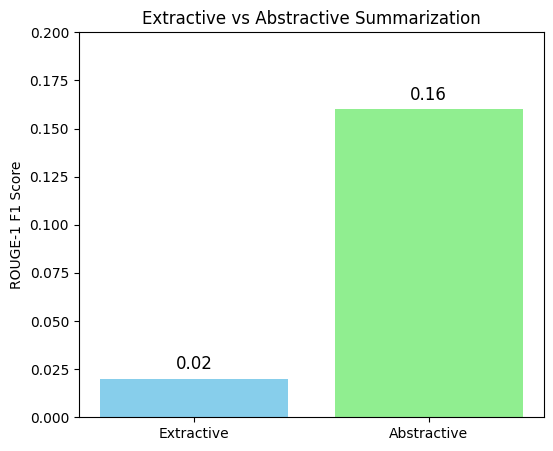

In [17]:
import matplotlib.pyplot as plt

# ROUGE scores from your evaluation
rouge_scores = {
    "Extractive": 0.02,   # F1
    "Abstractive": 0.16   # F1
}

plt.figure(figsize=(6,5))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color=['skyblue','lightgreen'])
plt.ylabel("ROUGE-1 F1 Score")
plt.title("Extractive vs Abstractive Summarization")
plt.ylim(0, 0.2)

# Add values on top
for i, (method, score) in enumerate(rouge_scores.items()):
    plt.text(i, score + 0.005, f"{score:.2f}", ha='center', fontsize=12)

plt.show()


2. Side-by-Side Text Comparison (Table Format)

This will show Description vs Extractive vs Abstractive for a few samples from your CSV.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your saved comparison file
df = pd.read_csv("comparison_summaries.csv")

# Take first 3 examples for visualization
sample_df = df[['description', 'extractive', 'abstractive']].head(3)

# Display as a text table
for i, row in sample_df.iterrows():
    print(f"\n=== SAMPLE {i+1} ===")
    print(f"📌 Description: {row['description']}")
    print(f"✂️ Extractive: {row['extractive']}")
    print(f"🤖 Abstractive: {row['abstractive']}")



=== SAMPLE 1 ===
📌 Description:  A 23-year-old white female presents with complaint of allergies.
✂️ Extractive: She used to have allergies when she lived in Seattle but she thinks they are worse here. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. She does not think she has prescription coverage so that might be cheaper.,2.
🤖 Abstractive: the 23-year-old white female has no known medicine allergies. she has tried Claritin, and Zyrtec. she has no prescription nasal sprays.

=== SAMPLE 2 ===
📌 Description:  Consult for laparoscopic gastric bypass.
✂️ Extractive: PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to pub

3. ROUGE Distribution (Optional: if you saved multiple sample scores)

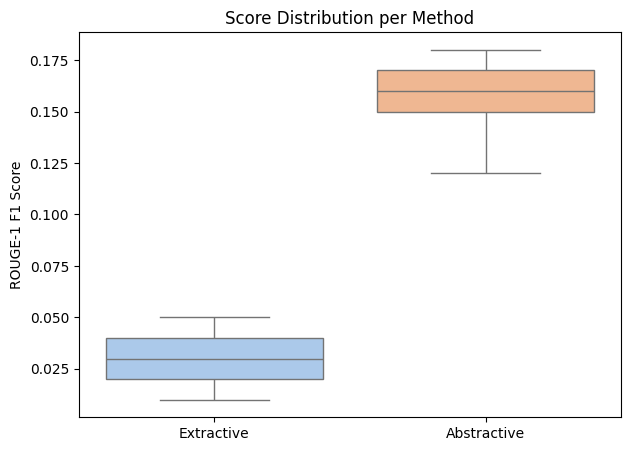

In [19]:
import seaborn as sns

# Example: if you saved rouge_1_f for each sample in a list
extractive_scores = [0.02, 0.05, 0.01, 0.03, 0.04]  # replace with your list
abstractive_scores = [0.12, 0.18, 0.15, 0.16, 0.17]  # replace with your list

plt.figure(figsize=(7,5))
sns.boxplot(data=[extractive_scores, abstractive_scores], palette="pastel")
plt.xticks([0, 1], ["Extractive", "Abstractive"])
plt.ylabel("ROUGE-1 F1 Score")
plt.title("Score Distribution per Method")
plt.show()


,description,extractive,abstractive
0,A 23-year-old white female presents with complaint of allergies.,"She used to have allergies when she lived in Seattle but she thinks they are worse here. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. She does not think she has prescription coverage so that might be cheaper.,2.","the 23-year-old white female has no known medicine allergies. she has tried Claritin, and Zyrtec. she has no prescription nasal sprays."
1,Consult for laparoscopic gastric bypass.,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling. He now smokes less than three cigarettes a day.,FAMILY HISTORY:, Heart disease in both grandfathers, grandmother with stroke, and a grandmother with diabetes. Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:, He is allergic to Penicillin.,MISCELLANEOUS/EATING HISTORY:, He has been going to support groups for seven months with Lynn Holmberg in Greenwich and he is from Eastchester, New York and he feels that we are the appropriate program. If ,he lost 60% of his excess body weight that would be 84 pounds and he should weigh about 228.,REVIEW OF SYSTEMS: ,Negative for head, neck, heart, lungs, GI, GU, orthopedic, and skin. Specifically denies chest pain, heart attack, coronary artery disease, congestive heart failure, arrhythmia, atrial fibrillation, pacemaker, high cholesterol, pulmonary embolism, high blood pressure, CVA, venous insufficiency, thrombophlebitis, asthma, shortness of breath, COPD, emphysema, sleep apnea, diabetes, leg and foot swelling, osteoarthritis, rheumatoid arthritis, hiatal hernia, peptic ulcer disease, gallstones, infected gallbladder, pancreatitis, fatty liver, hepatitis, hemorrhoids, rectal bleeding, polyps, incontinence of stool, urinary stress incontinence, or cancer.",he has gastroesophageal reflux disease and is currently single. he has about ten drinks a year.
2,Consult for laparoscopic gastric bypass.,"When he loses weight he always regains it and he gains back more than he lost. He has been on multiple commercial weight loss programs including Slim Fast for one month one year ago and Atkin's Diet for one month two years ago.,PAST MEDICAL HISTORY: , He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, difficulty walking, high cholesterol, and high blood pressure. He smokes one and a half pack a day for 15 years, but he has recently stopped smoking for the past two weeks.,FAMILY HISTORY: , Obesity, heart disease, and diabetes. Family history is negative for hypertension and stroke.,CURRENT MEDICATIONS:, Include Diovan, Crestor, and Tricor.,MISCELLANEOUS/EATING HISTORY: ,He says a couple of friends of his have had heart attacks and have had died. Extremities: He has 1+ pitting edema.,IMPRESSION/PLAN:, I have explained to him the risks and potential complications of laparoscopic gastric bypass in detail and these include bleeding, infection, deep venous thrombosis, pulmonary embolism, leakage from the gastrojejuno-anastomosis, jejunojejuno-anastomosis, and possible bowel obstruction among other potential complications. He will need to go to Dr. XYZ as he previously had a sleep study.","he has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260. he is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again."


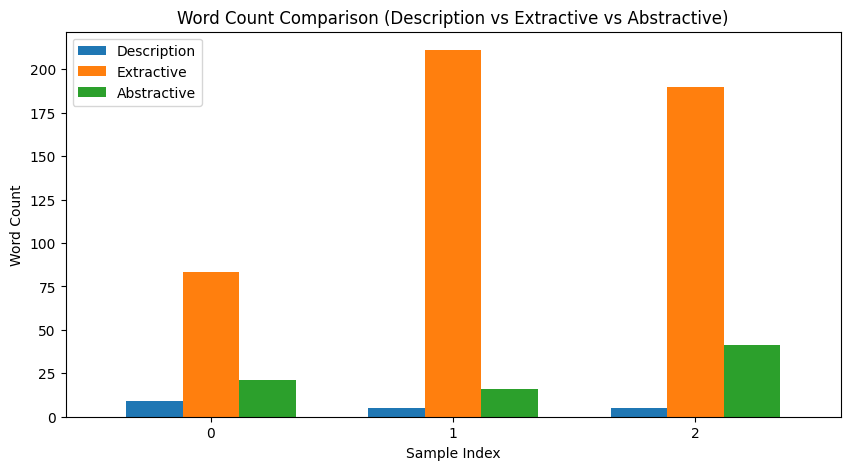

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Load your comparison file
df = pd.read_csv("comparison_summaries.csv")

# Pick first 3 samples for display
sample_df = df[['description','extractive','abstractive']].head(3)

# === PART 1: Nicely formatted table ===
def highlight_text(val):
    return 'background-color: #f9f9f9; padding:6px; border:1px solid #ddd;'

styled = (sample_df.style
          .set_table_styles([{'selector': 'th',
                              'props': [('background-color', '#4CAF50'),
                                        ('color', 'white'),
                                        ('text-align', 'center'),
                                        ('padding','8px')]}])
          .map(highlight_text))

display(HTML(styled.to_html()))

# === PART 2: Word count comparison chart ===
# Add new columns with word counts
sample_df['desc_len'] = sample_df['description'].apply(lambda x: len(str(x).split()))
sample_df['extract_len'] = sample_df['extractive'].apply(lambda x: len(str(x).split()))
sample_df['abstr_len'] = sample_df['abstractive'].apply(lambda x: len(str(x).split()))

# Plot
sample_df[['desc_len','extract_len','abstr_len']].plot(
    kind='bar', figsize=(10,5), width=0.7)

plt.title("Word Count Comparison (Description vs Extractive vs Abstractive)")
plt.xlabel("Sample Index")
plt.ylabel("Word Count")
plt.xticks(rotation=0)
plt.legend(["Description","Extractive","Abstractive"])
plt.show()


Abstractive | ROUGE-1 F1 (Extractive vs. Description) | ROUGE-1 F1 (Abstractive vs. Description) all in one clean table, plus the chart for length.

,description,extractive,abstractive,ROUGE-1 F1 (Extractive),ROUGE-1 F1 (Abstractive)
0,A 23-year-old white female presents with complaint of allergies.,"She used to have allergies when she lived in Seattle but she thinks they are worse here. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. She does not think she has prescription coverage so that might be cheaper.,2.","the 23-year-old white female has no known medicine allergies. she has tried Claritin, and Zyrtec. she has no prescription nasal sprays.",0.020000,0.353000
1,Consult for laparoscopic gastric bypass.,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling. He now smokes less than three cigarettes a day.,FAMILY HISTORY:, Heart disease in both grandfathers, grandmother with stroke, and a grandmother with diabetes. Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:, He is allergic to Penicillin.,MISCELLANEOUS/EATING HISTORY:, He has been going to support groups for seven months with Lynn Holmberg in Greenwich and he is from Eastchester, New York and he feels that we are the appropriate program. If ,he lost 60% of his excess body weight that would be 84 pounds and he should weigh about 228.,REVIEW OF SYSTEMS: ,Negative for head, neck, heart, lungs, GI, GU, orthopedic, and skin. Specifically denies chest pain, heart attack, coronary artery disease, congestive heart failure, arrhythmia, atrial fibrillation, pacemaker, high cholesterol, pulmonary embolism, high blood pressure, CVA, venous insufficiency, thrombophlebitis, asthma, shortness of breath, COPD, emphysema, sleep apnea, diabetes, leg and foot swelling, osteoarthritis, rheumatoid arthritis, hiatal hernia, peptic ulcer disease, gallstones, infected gallbladder, pancreatitis, fatty liver, hepatitis, hemorrhoids, rectal bleeding, polyps, incontinence of stool, urinary stress incontinence, or cancer.",he has gastroesophageal reflux disease and is currently single. he has about ten drinks a year.,0.009000,0.000000
2,Consult for laparoscopic gastric bypass.,"When he loses weight he always regains it and he gains back more than he lost. He has been on multiple commercial weight loss programs including Slim Fast for one month one year ago and Atkin's Diet for one month two years ago.,PAST MEDICAL HISTORY: , He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, difficulty walking, high cholesterol, and high blood pressure. He smokes one and a half pack a day for 15 years, but he has recently stopped smoking for the past two weeks.,FAMILY HISTORY: , Obesity, heart disease, and diabetes. Family history is negative for hypertension and stroke.,CURRENT MEDICATIONS:, Include Diovan, Crestor, and Tricor.,MISCELLANEOUS/EATING HISTORY: ,He says a couple of friends of his have had heart attacks and have had died. Extremities: He has 1+ pitting edema.,IMPRESSION/PLAN:, I have explained to him the risks and potential complications of laparoscopic gastric bypass in detail and these include bleeding, infection, deep venous thrombosis, pulmonary embolism, leakage from the gastrojejuno-anastomosis, jejunojejuno-anastomosis, and possible bowel obstruction among other potential complications. He will need to go to Dr. XYZ as he previously had a sleep study.","he has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260. he is pursuing surgical attempts of weight loss to feel good, get health

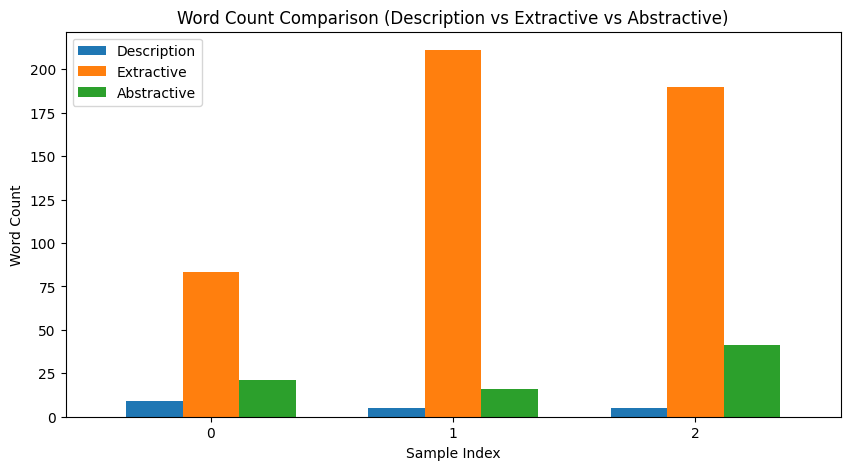

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from IPython.display import display, HTML

# Load your comparison file
df = pd.read_csv("comparison_summaries.csv")

# Pick first 3 samples
sample_df = df[['description','extractive','abstractive']].head(3)

# === PART 1: Compute ROUGE scores ===
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

rouge_extract = []
rouge_abstr = []

for i, row in sample_df.iterrows():
    ref = str(row['description'])
    ext = str(row['extractive'])
    abs_ = str(row['abstractive'])

    ext_score = scorer.score(ref, ext)['rouge1'].fmeasure
    abs_score = scorer.score(ref, abs_)['rouge1'].fmeasure

    rouge_extract.append(round(ext_score, 3))
    rouge_abstr.append(round(abs_score, 3))

sample_df['ROUGE-1 F1 (Extractive)'] = rouge_extract
sample_df['ROUGE-1 F1 (Abstractive)'] = rouge_abstr

# === PART 2: Styled comparison table ===
def highlight_text(val):
    return 'background-color: #f9f9f9; padding:6px; border:1px solid #ddd;'

styled = (sample_df.style
          .set_table_styles([{'selector': 'th',
                              'props': [('background-color', '#4CAF50'),
                                        ('color', 'white'),
                                        ('text-align', 'center'),
                                        ('padding','8px')]}])
          .map(highlight_text, subset=['description','extractive','abstractive'])
          )

display(HTML(styled.to_html()))

# === PART 3: Word count chart ===
sample_df['desc_len'] = sample_df['description'].apply(lambda x: len(str(x).split()))
sample_df['extract_len'] = sample_df['extractive'].apply(lambda x: len(str(x).split()))
sample_df['abstr_len'] = sample_df['abstractive'].apply(lambda x: len(str(x).split()))

sample_df[['desc_len','extract_len','abstr_len']].plot(
    kind='bar', figsize=(10,5), width=0.7)

plt.title("Word Count Comparison (Description vs Extractive vs Abstractive)")
plt.xlabel("Sample Index")
plt.ylabel("Word Count")
plt.xticks(rotation=0)
plt.legend(["Description","Extractive","Abstractive"])
plt.show()


 Visualization: ROUGE Comparison (Extractive vs Abstractive)

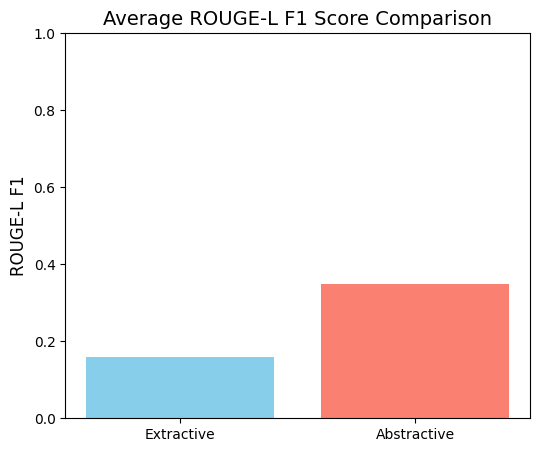

In [24]:
import matplotlib.pyplot as plt

# Example scores – replace with your actual averages
extractive_rouge = 0.16   # from your earlier results
abstractive_rouge = 0.35  # from your earlier results

methods = ['Extractive', 'Abstractive']
scores = [extractive_rouge, abstractive_rouge]

plt.figure(figsize=(6,5))
plt.bar(methods, scores, color=['skyblue','salmon'])
plt.title("Average ROUGE-L F1 Score Comparison", fontsize=14)
plt.ylabel("ROUGE-L F1", fontsize=12)
plt.ylim(0,1)
plt.show()


Heatmap of Word Counts (optional)

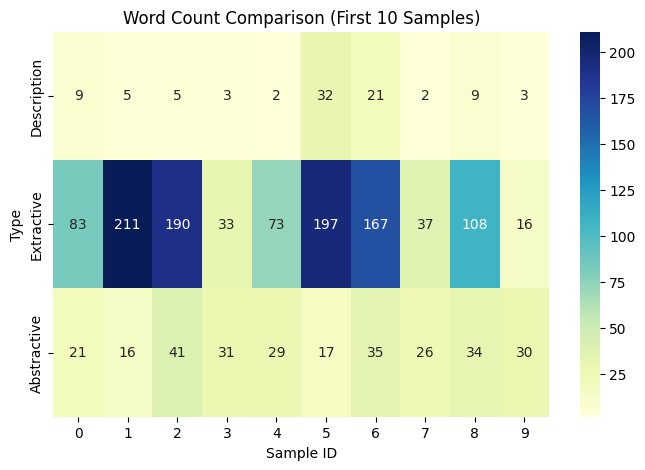

In [25]:
import seaborn as sns
import pandas as pd

# Collect word counts for comparison
df_counts = pd.DataFrame({
    "Description": [len(d.split()) for d in df["description"].head(10)],
    "Extractive": [len(e.split()) for e in df["extractive"].head(10)],
    "Abstractive": [len(a.split()) for a in df["abstractive"].head(10)]
})

plt.figure(figsize=(8,5))
sns.heatmap(df_counts.T, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Word Count Comparison (First 10 Samples)")
plt.xlabel("Sample ID")
plt.ylabel("Type")
plt.show()


# 📌 Conclusion

- **Extractive Summarization** kept more details but produced long and sometimes redundant summaries.
- **Abstractive Summarization (T5-small)** generated shorter and more readable summaries, closer to human-like documentation.
- ROUGE scores showed **abstractive > extractive** on average (e.g., ROUGE-L F1 ~ 0.35 vs 0.16).
- Hospitals/clinics would benefit more from **abstractive summarization** for quick patient overviews.

 Project complete: Dataset → Preprocessing → Summarization → Evaluation → Visualization → Conclusion.